# TIMING DIAGRAM

## PRF and looking angle choice limited by nadir return
The widest-possible swath PRF choice of above only depends on the antenna width and looking angle. If we want to minimize the influence of nadir return we have to choose theta so that the nadir appears at the beginning or at the end of the swath.

The enveloped slant range of the nadir return will be:
\begin{equation}
    R_{nadir} = H \% \left(\dfrac{c\ \text{PRI}}{2}\right) + n \left( \frac{c\ \text{PRI}}{2}\right)
\end{equation}
The term $  H \% \left(\dfrac{c\ \text{PRI}}{2}\right)$ needs to be zero to hide the nadir return "under" the transmit event.


Instead of slant range we can use the Ground range, and instead of the PRI we can use the PRF to produce a timing diagram.
We can also look at the transmit and receive events wrapped positions in range as function of the PRF.

The position of the trasmit event in slant range is bounded by:
\begin{equation}
    R_{transmit} = n \left( \dfrac{c\ \text{PRI}}{2} \right) \pm \left( \dfrac{c\ \text{PRI}\ \delta }{4} \right)
\end{equation}
wiht $\delta$ = duty cycle

NOTE: there is an error in the timing diagram code, the duty cycle is doubled, a value that's half of the desired one shall be used!

## Timing diagram

In [1]:
import numpy as np

h = 500e3

# PRF axis
prf = np.linspace(1, 10e3, 10000)

# slant range axis
# max slant range (orizon distance from orbit)
rmax = np.sqrt((h + 6371e3) ** 2 - 6371e3 ** 2)
r = np.linspace(h, rmax - 100, 10000)


def nadir_return_plotter_rg(ax, h, prf_min, prf_max, c=299792458, prf_resolution=1):
    """
    plots the nadir returns for the timing diagram on the passed axis
    :param ax: matplotlib axis object
    :param h: platform height
    :param prf_min: minimum prf
    :param prf_max: maximum prf
    :param c: c: optional default speed of light
    :param prf_resolution: optional default 1 HZ, PRF axis resolution
    :return:
    """
    # horizon slant range
    rmax = np.floor(np.sqrt((h + 6371e3) ** 2 - 6371e3 ** 2))
    # step 1: find n min and n max
    n_min = np.floor(2 * h * prf_min / c)
    n_max = np.floor(2 * rmax * prf_max / c)
    nn = np.arange(n_min, n_max)
    #nn = np.arange(1, 20)

    # step 2: find m min and m max (how many times can H be divided by c/2prf)
    m_min = np.floor(prf_min * 2 * h / c)
    m_max = np.ceil(prf_max * 2 * h / c)
    mm = np.arange(m_min, m_max)
    # for every m
    for m in mm:
        # step 3 find the prf axis of validity
        ppmin = m * c / (2 * h) + prf_resolution
        ppmax = (m + 1) * c / (2 * h) - prf_resolution
        if ppmax > ppmin:
            prff = np.linspace(ppmin, ppmax, int(1 + np.abs((ppmax - ppmin)) / prf_resolution))
        else:
            prff = np.zeros(1)
        # for every n
        for n in nn:
            # step 4: find the slant range of the nadir return
            R_nad = h % (c / (2 * prff)) + n * (c / (prff * 2))
            R_nad = np.where(R_nad > rmax, rmax, R_nad)
            # step 5: find the ground range of the nadir return
            rg_nad, th = range_slant_to_ground(R_nad, h)
            # step 6: plot the damn thing
            ax.plot(prff, rg_nad / 1000, 'k')


def range_transmit_event(n, dutycycle, prf, h=500e3, c=299792458):
    """
    finds a list of n curves for the enveloped slant ranges associated to transmit events (bot and eot)
    :param n: maximum order of the return
    :param dutycycle: duty cycle
    :param prf: prf axis
    :param c: optional default speed of light
    :return:
    """
    rmax = np.floor(np.sqrt((h + 6371e3) ** 2 - 6371e3 ** 2))
    transmits = []
    for nn in n:
        bot = nn * (c / (2 * prf)) - (c * dutycycle / (2 * prf))
        eot = nn * (c / (2 * prf)) + (c * dutycycle / (2 * prf))
        bot = np.where(bot < rmax, bot, rmax)
        eot = np.where(eot < rmax, eot, rmax)
        tev = (bot, eot)
        transmits.append(tev)
    return transmits

In [2]:
n = np.arange(0, 30)
transmit_events = range_transmit_event(n, .25, prf)

In [3]:
from design_functions import *

# conversion to ground range
transmit_events_rg = []
transmit_events_theta = []
for nn in range(len(n)):
    #nadir_return_rg, nadir_return_theta = range_slant_to_ground(nadir_returns[nn], h)
    transmit_event_rg_bot, transmit_event_theta_bot = range_slant_to_ground(transmit_events[nn][0])
    transmit_event_rg_eot, transmit_event_theta_eot = range_slant_to_ground(transmit_events[nn][1])
    transmit_events_rg.append((transmit_event_rg_bot, transmit_event_rg_eot))
    transmit_events_theta.append((transmit_event_theta_bot, transmit_event_theta_eot))


C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:48: RuntimeWarning: invalid value encountered in arccos
  beta = arccos(((re + h) ** 2 - re ** 2 + rs ** 2) / (2 * (re + h) * rs))
C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:49: RuntimeWarning: invalid value encountered in arccos
  alpha = arccos(((re + h) ** 2 + re ** 2 - rs ** 2) / (2 * (re + h) * re))


C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:48: RuntimeWarning: invalid value encountered in arccos
  beta = arccos(((re + h) ** 2 - re ** 2 + rs ** 2) / (2 * (re + h) * rs))
C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:49: RuntimeWarning: invalid value encountered in arccos
  alpha = arccos(((re + h) ** 2 + re ** 2 - rs ** 2) / (2 * (re + h) * re))


(300.0, 2000.0)

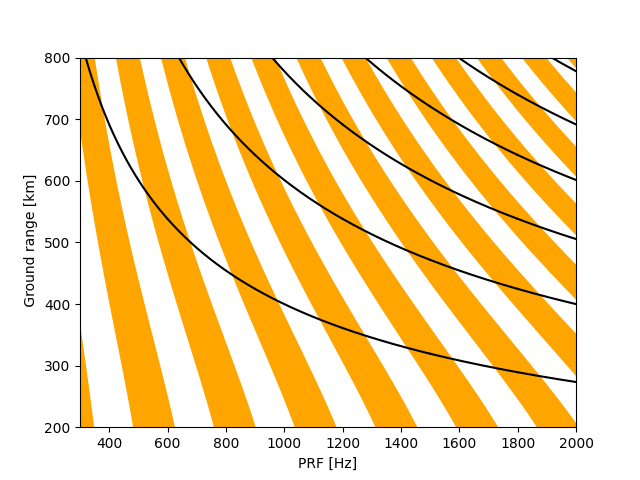

In [4]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.use('Qt5Agg')
%matplotlib widget
# plotting
fig, ax = plt.subplots(1)
nadir_return_plotter_rg(ax, h, prf[0], prf[-1])
transmit_events_rg = np.where(np.isnan(transmit_events_rg), 0, transmit_events_rg)
for nn in range(len(n)):
    # bot
    #ax.plot(prf, transmit_events_rg[nn][0] / 1000, 'r')
    # eot
    #ax.plot(prf, transmit_events_rg[nn][1] / 1000, 'g')
    ax.fill_between(prf, transmit_events_rg[nn][1] / 1000, transmit_events_rg[nn][0] / 1000, color='orange')
ax.set_xlabel('PRF [Hz]')
ax.set_ylabel(' Ground range [km]')
ax.set_ylim(200, 800)
ax.set_xlim(300, 2000)
# todo add second axis for incidence angle


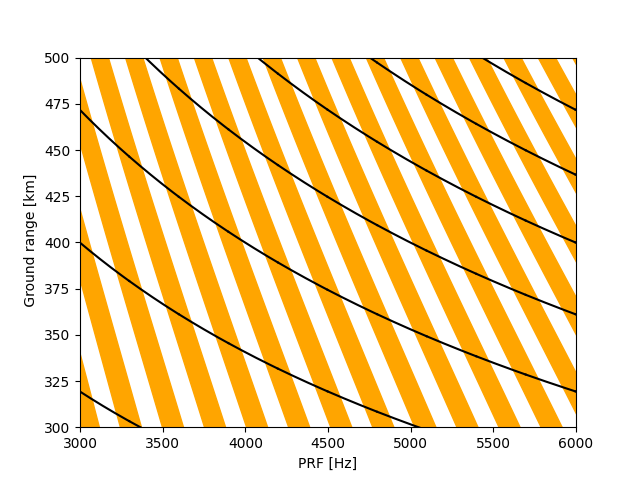

In [5]:
ax.set_ylim(300, 500)
ax.set_xlim(3000, 6000)
plt.show()

In [6]:
# secondary axis functions
def rgtotheta(rg, h=500e3, re=6371e3):
    alpha = rg / re
    # using Carnot's cosine teorem
    # slant range
    rs = np.sqrt(re ** 2 + (re + h) ** 2 - 2 * re * (re + h) * np.cos(alpha))
    # theta
    beta = arccos(((re + h) ** 2 - re ** 2 + rs ** 2) / (2 * (re + h) * rs))
    theta = alpha + beta
    return theta * 180 / np.pi


from design_functions import *


def thetatorg(theta, h=500e3, re=6371e3):
    # just reuse this
    rss, rg = range_from_theta(theta, h, re)
    return rg

In [13]:
rg = np.linspace(300, 500, 9)*1000
theta = rgtotheta(rg, h)

In [16]:
rg/1000

array([300., 325., 350., 375., 400., 425., 450., 475., 500.])

In [14]:
theta

array([33.29909874, 35.50643216, 37.61536784, 39.62817907, 41.54777067,
       43.37751094, 45.12108711, 46.78238433, 48.36538663])

# AS A SINGLE FUNCTION

In [17]:
# plotter
def time_diagram_plotter(ax, prf, dutycycle, h=500e3, re=6371e3, c=299792458):
    """
    plots a timing diagram over the given axis
    :param ax: matplotlib axis
    :param prf: pulse repetition frequency
    :param dutycycle: duty cycle of the radar
    :param h: satellite height
    :param re: earth radius
    :param c: optional default speed of light
    :return:
    """
    nadir_return_plotter_rg(ax, h, prf[0], prf[-1])
    n = np.arange(0, 60)
    transmit_events = range_transmit_event(n, dutycycle, prf)
    # conversion to ground range
    transmit_events_rg = []
    transmit_events_theta = []
    for nn in range(len(n)):
        #nadir_return_rg, nadir_return_theta = range_slant_to_ground(nadir_returns[nn], h)
        transmit_event_rg_bot, transmit_event_theta_bot = range_slant_to_ground(transmit_events[nn][0])
        transmit_event_rg_eot, transmit_event_theta_eot = range_slant_to_ground(transmit_events[nn][1])
        transmit_events_rg.append((transmit_event_rg_bot, transmit_event_rg_eot))
        transmit_events_theta.append((transmit_event_theta_bot, transmit_event_theta_eot))

    transmit_events_rg = np.where(np.isnan(transmit_events_rg), 0, transmit_events_rg)
    for nn in range(len(n)):
        ax.fill_between(prf, transmit_events_rg[nn][1] / 1000, transmit_events_rg[nn][0] / 1000, color='orange')
    ax.set_xlabel('PRF [Hz]')
    ax.set_ylabel(' Ground range [km]')


C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:48: RuntimeWarning: invalid value encountered in arccos
  beta = arccos(((re + h) ** 2 - re ** 2 + rs ** 2) / (2 * (re + h) * rs))
C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:49: RuntimeWarning: invalid value encountered in arccos
  alpha = arccos(((re + h) ** 2 + re ** 2 - rs ** 2) / (2 * (re + h) * re))


(300.0, 2000.0)

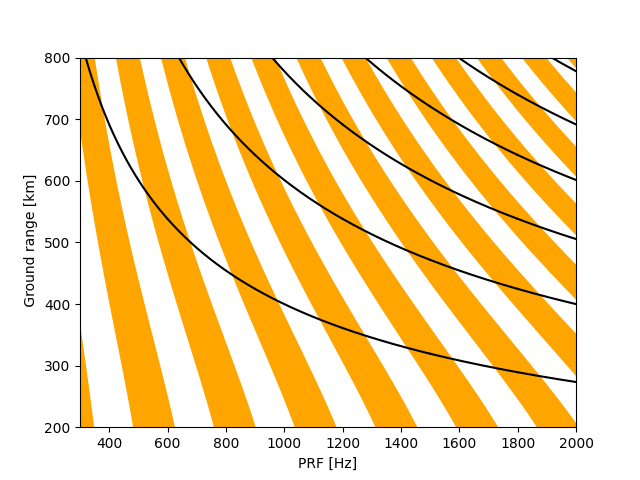

In [18]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.use('Qt5Agg')
%matplotlib widget
# plotting
fig, ax = plt.subplots(1)

time_diagram_plotter(ax, prf, 0.25, h)

ax.set_xlabel('PRF [Hz]')
ax.set_ylabel(' Ground range [km]')
ax.set_ylim(200, 800)
ax.set_xlim(300, 2000)